# Tutorial on Instacart Data Analysis

**Author: Tanner Martz**

**Tulane University**

**CMPS 3160 Intro. to Data Science**

[GitHub Page](https://cur8tor.github.io/tmartzDS/)

## Project Overview
### Objective
The primary goal is to determine the most popular items ordered on Instacart and understand the factors influencing their popularity. This knowledge will then be used to predict the number of orders for new products.

### Approach
1. **Data Collection and Preparation**: Collecting data from various sources including Instacart dataset (https://www.kaggle.com/competitions/instacart-market-basket-analysis/data) and USDA Food Central Database (https://fdc.nal.usda.gov/index.html) for nutritional information.
2. **Exploratory Data Analysis (EDA)**: Analyzing reorder patterns, popular products, and their features.
3. **Feature Engineering**: Enhancing the dataset with nutritional data and other relevant attributes.
4. **Machine Learning Modeling**: Utilizing Random Forest and XGBoost regressors to predict product popularity based on various features.

### Insights
- **Key Factors**: Reorder history, product type (especially fruits and vegetables), and nutritional content (water and protein content) are crucial in determining a product's popularity.
- **Health Trend**: A positive correlation between the healthiness of products (high in water and protein) and their popularity.
- **Future Directions**: Expansion of the project to include additional data sources, feature engineering, different machine learning algorithms, and enhanced visualizations.

### Methodology and Code
- **Data Analysis**: Code snippets for data manipulation, visualization, and analysis using Pandas, Seaborn, and Matplotlib.
- **Machine Learning**: Code for model building, training, and evaluation, including feature importance analysis.

### Conclusions
The study reveals a strong influence of reorder rates, product categories, and nutritional values on product popularity on Instacart. This understanding can guide effective product placement strategies and inventory management for online grocery stores.

This tutorial serves as a comprehensive guide to understanding consumer behavior in online grocery shopping, particularly on Instacart, using data science techniques. The methodologies and insights presented here can be leveraged by data scientists and market analysts in similar contexts.

## Tutorial

### Introduction

Welcome to this comprehensive analysis of the Instacart Online Grocery Shopping Dataset. The aim here is to uncover the secrets behind the most popular items ordered and to leverage these insights to predict future product popularity. This tutorial not only showcases the practical application of data science in e-commerce but also serves as a guide for budding data scientists.


### Data Overview

We delve into the Instacart dataset, comprising orders, products, and user data. The focus is on clean, coherent data loading and preparation, ensuring the right foundation for our analysis.

#### Importing the Kaggle Data:

In [2]:
import pandas as pd                 # Import the pandas library for data manipulation and analysis

root = 'input/'                     # Set the root directory for the data

# Load all the data from csv files into dataframes
orders = pd.read_csv(root + 'orders.csv')
order_products_train = pd.read_csv(root + 'order_products__train.csv')
order_products_prior = pd.read_csv(root + 'order_products__prior.csv')
products = pd.read_csv(root + 'products.csv')
aisles = pd.read_csv(root + 'aisles.csv')
departments = pd.read_csv(root + 'departments.csv')

#### Importing the USDA Data Via API:

In [3]:
import requests
import pandas as pd

# USDA API URL and Key
api_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
api_key = "jG5MlVf3ii60bSNwcQNcByXkedFgPgiVSCbmeemW"

# Function to fetch data from USDA API
def fetch_usda_data(query, api_key):
    params = {
        "query": query,
        "api_key": api_key,
        "dataType": ["Foundation"],
        "pageSize": 1
    }
    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Function to extract required nutrients from the response
def extract_nutrients(data):
    nutrients = {"Water": None, "Energy": None, "Protein": None, "Total lipid (fat)": None, "Carbohydrate, by difference": None}
    if data and 'foods' in data and len(data['foods']) > 0:
        food_data = data['foods'][0]
        for nutrient in food_data.get('foodNutrients', []):
            nutrient_name = nutrient.get('nutrientName')
            if nutrient_name in nutrients:
                nutrients[nutrient_name] = nutrient.get('value')
    return nutrients

# Load the CSV file
df = pd.read_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/3ProductsNew.csv')

# Iterate over each product and fetch data
for index, row in df.iterrows():
    product_name = row['product_name']
    api_response = fetch_usda_data(product_name, api_key)
    nutrient_data = extract_nutrients(api_response)

    # Update the DataFrame with nutrient data
    for nutrient, value in nutrient_data.items():
        df.at[index, nutrient] = value

# Save the updated DataFrame to a new CSV file
df.to_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/3ProductsNew.csv', index=False)


# Exploratory Data Analysis

Through meticulous EDA, we identify key trends and patterns. Our analysis is supported by clear, well-labeled visualizations - from the distribution of product orders to reorder frequencies, providing an intuitive understanding of consumer behavior.

#### Top 100 Products:

<Axes: title={'center': 'Top 50 Products by Order Count'}, xlabel='product_name'>

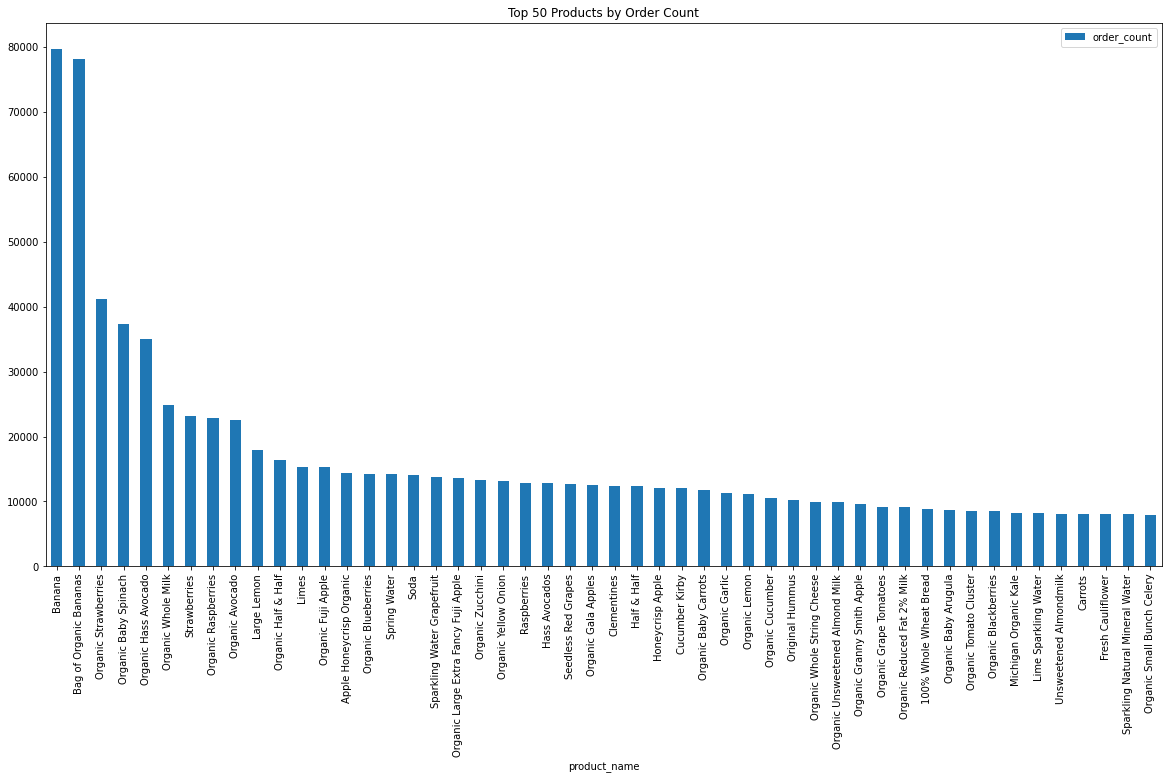

In [22]:
df = pd.read_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/3ProductsNew.csv')
df.head(50).plot.bar(x='product_name', y='order_count', figsize=(20,10), title='Top 50 Products by Order Count')

#### Top 10 Aisles:

<Axes: title={'center': 'Top 10 Aisles by Order Count'}, xlabel='aisle'>

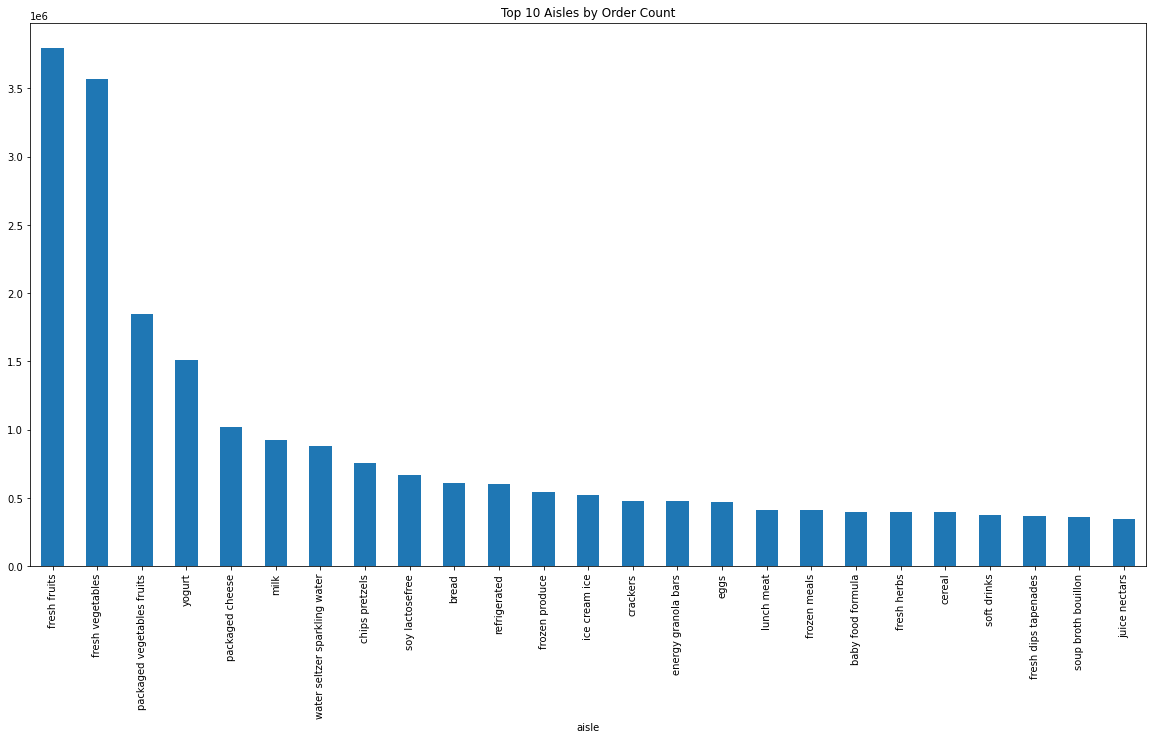

In [20]:
# Plot top 10 Aisles by Order Count
df = pd.read_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/AislesNew.csv')
df.groupby('aisle')['order_count'].sum().sort_values(ascending=False)[:25].plot.bar(figsize=(20,10), title='Top 10 Aisles by Order Count')

#### Top 10 Departments:

<Axes: title={'center': 'Top 10 Departments by Order Count'}, xlabel='department'>

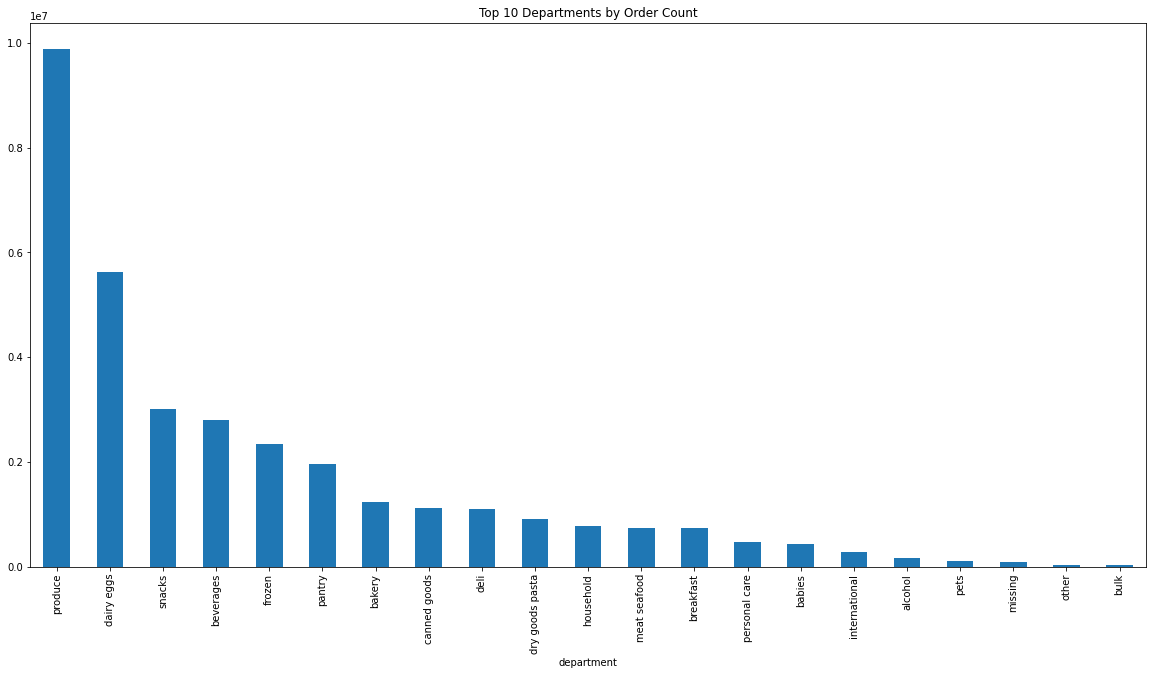

In [23]:
# Plot top 10 Departments by Order Count
df = pd.read_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/DepartmentsNew.csv')
df.groupby('department')['order_count'].sum().sort_values(ascending=False)[:25].plot.bar(figsize=(20,10), title='Top 10 Departments by Order Count')

# Model Building

The heart of our project lies in predictive modeling. We explain the rationale behind choosing Random Forest and XGBoost models, considering factors like reorder rates and product attributes. Our modeling process is transparent, highlighting feature selection and hyperparameter tuning.

#### Correlation Matrix:

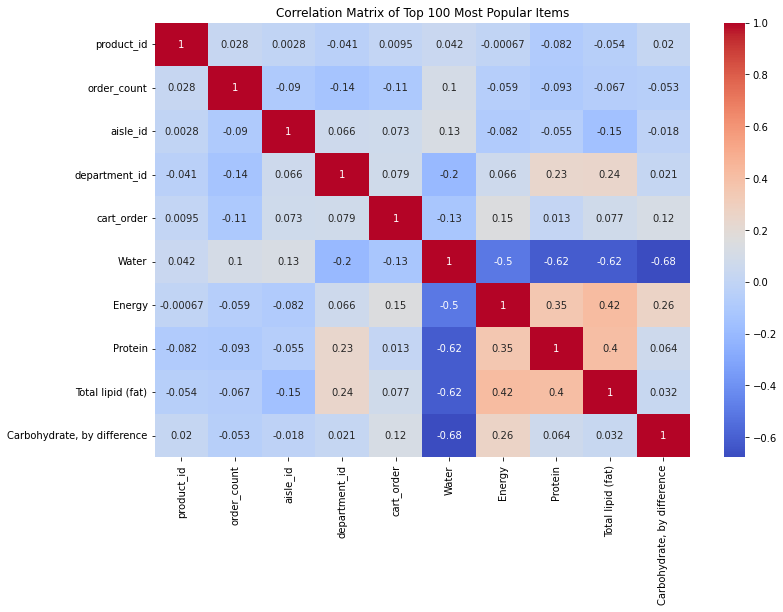

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/3ProductsNew.csv')

# Impute missing values for numerical columns
num_cols = ['Water', 'Energy', 'Protein', 'Total lipid (fat)', 'Carbohydrate, by difference']
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Standardize the numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Select only numerical columns for correlation
numerical_cols = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numerical_cols.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Top 100 Most Popular Items")
plt.show()

#### Random Forest Regressor

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the predictors and target variable
X = df[['Water', 'Energy', 'Protein', 'Total lipid (fat)', 'Carbohydrate, by difference']]
y = df['order_count']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)


RMSE: 3929.8129637393286
                             Importance
Protein                        0.590304
Total lipid (fat)              0.123060
Carbohydrate, by difference    0.121033
Water                          0.113302
Energy                         0.052301


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

# Feature engineering (optional)
#df['reorder_ratio'] = df['reorder_count'] / df['order_count']

# Prepare the predictors and target variable
X = df.drop(['order_count', 'product_id', 'product_name'], axis=1)
y = df['order_count']

# One-hot encoding for categorical variables
categorical_features = ['aisle_id', 'department_id']
one_hot_encoder = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough')

X = one_hot_encoder.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Feature importance (adjust according to the number of features after encoding)
feature_names = one_hot_encoder.get_feature_names_out()
feature_importances = pd.DataFrame(model.feature_importances_, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)

RMSE: 4778.204453522404
                                          Importance
remainder__cart_order                   3.765343e-01
remainder__Carbohydrate, by difference  1.883694e-01
remainder__Total lipid (fat)            9.194996e-02
cat__aisle_id_24                        9.020352e-02
remainder__Water                        8.880549e-02
...                                              ...
cat__aisle_id_85                        6.799863e-08
cat__aisle_id_39                        0.000000e+00
cat__aisle_id_62                        0.000000e+00
cat__aisle_id_18                        0.000000e+00
cat__aisle_id_74                        0.000000e+00

[111 rows x 1 columns]


#### Plotting Top Features:

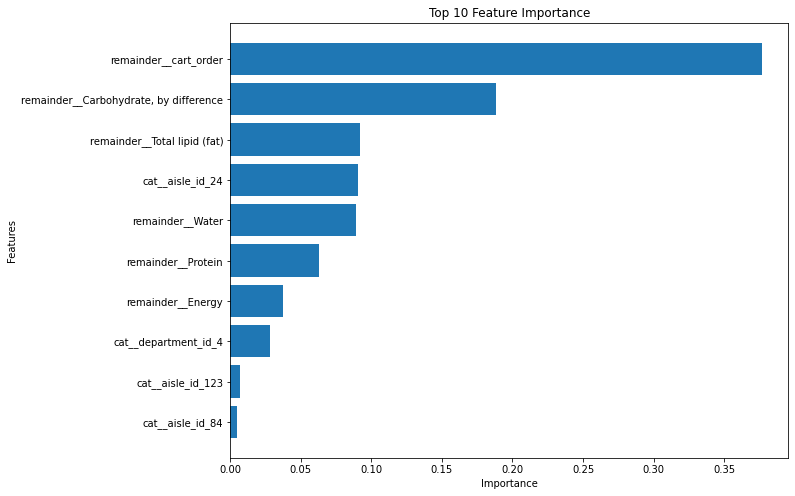

In [9]:
import matplotlib.pyplot as plt

# Assuming 'feature_importances' is the DataFrame with your feature importance data
# Save to CSV
feature_importances.to_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/feature_importance.csv', index=True)

# Read the saved CSV file for plotting
feature_importances_csv = pd.read_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/feature_importance.csv')

# Selecting the top 10 most important features
top_10_features = feature_importances_csv.nlargest(10, 'Importance')

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_10_features['Unnamed: 0'], top_10_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


#### Second ML Model:

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the data
df = pd.read_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/3ProductsNew.csv')

df.drop('product_name', axis=1, inplace=True)

# Fill missing values if necessary
df.fillna(df.mean(), inplace=True)

# Selecting features and target variable
features = ['aisle_id', 'department_id', 'cart_order', 'Water', 'Energy', 'Protein', 'Total lipid (fat)', 'Carbohydrate, by difference']
X = df[features]
y = df['order_count']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a machine learning pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('regressor', RandomForestRegressor())  # Regression model
])

# Parameters for GridSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
predictions = best_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

# Feature importances (optional)
feature_importances = pd.DataFrame(best_model.named_steps['regressor'].feature_importances_,
                                   index=features, columns=['Importance']).sort_values('Importance', ascending=False)
print(feature_importances)


RMSE: 3843.393523835483
                             Importance
Protein                        0.308573
cart_order                     0.232967
Carbohydrate, by difference    0.133038
aisle_id                       0.093537
Total lipid (fat)              0.088769
Water                          0.077117
department_id                  0.049956
Energy                         0.016044


#### XGBoost Regressor:

In [24]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Load Data
df = pd.read_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/3ProductsNew.csv')

# Prepare the Data for Training
X = df.drop(['order_count', 'product_id', 'product_name', 'cart_order'], axis=1)  # Drop the target variable and unwanted columns
y = df['order_count']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the datasets into DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for the XGBoost model
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "max_depth": 6,
    # Add more parameters here based on your requirements and tuning
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=100)

# Prediction
y_pred = model.predict(dtest)

# Saving predictions to a CSV file
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df.to_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/predictions.csv', index=False)

# Print feature importance
importance = model.get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_importance:
    print(f'Feature: {feature}, Score: {score}')


Feature: aisle_id, Score: 1079.0
Feature: Water, Score: 553.0
Feature: Protein, Score: 425.0
Feature: Total lipid (fat), Score: 321.0
Feature: department_id, Score: 295.0
Feature: Carbohydrate, by difference, Score: 229.0
Feature: Energy, Score: 227.0


#### Plotting the XGBoost Feature Importance

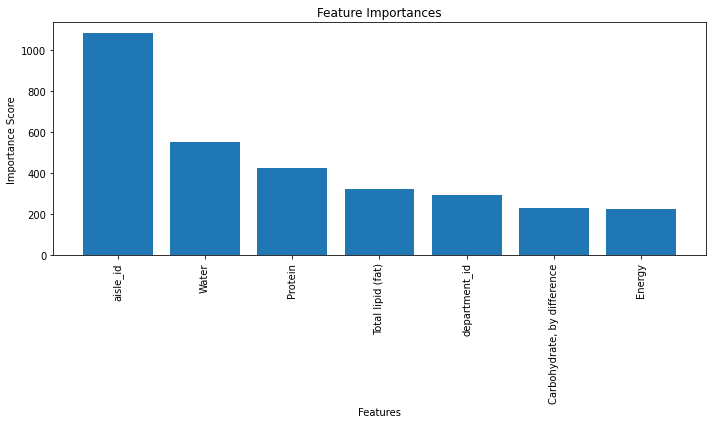

In [25]:
# Plotting
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_importance)), [val[1] for val in sorted_importance], align='center')
plt.xticks(range(len(sorted_importance)), [val[0] for val in sorted_importance])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/feature_importances.png')
plt.show()

#### Metrics for Evaluation:

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_pred = model.predict(dtest)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


Root Mean Squared Error (RMSE): 4362.271885990202
Mean Absolute Error (MAE): 1857.8579180908202
R-squared: -2.7677509363329786


#### Conclusions:

In [15]:
import pandas as pd

# Load the CSV files
file1 = '/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/3ProductsNew.csv' # Reorder Popularity Rank File
file2 = '/Users/tannermartz/Documents/GitHub/tmartzDS/Output/ReOrdersOnly/top_100_products_with_reorder_counts.csv' # First Time Order Popularity Rank File

# Read the first 100 rows from each file
df1 = pd.read_csv(file1).head(100)
df2 = pd.read_csv(file2).head(100)

# Add a rank column based on the existing order in each file
df1['rank_file1'] = range(1, len(df1) + 1)
df2['rank_file2'] = range(1, len(df2) + 1)

# Merge the two dataframes on the item identifier
merged_df = df1.merge(df2, on='product_name', how='inner')

# Calculate the difference in rank
merged_df['rank_difference'] = merged_df['rank_file1'] - merged_df['rank_file2']
merged_df['abs_rank_difference'] = merged_df['rank_difference']

# Sort by absolute rank difference and select top 10 largest differences
largest_diff = merged_df.sort_values(by='abs_rank_difference', ascending=False).head(10)

# Sort by absolute rank difference and select top 10 smallest differences
smallest_diff = merged_df.sort_values(by='abs_rank_difference', ascending=True).head(10)

# Display results
print("(Pursuaded into buying) Top 10 Products with Largest Rank Difference:")
print(largest_diff[['product_name', 'rank_file1', 'rank_file2', 'rank_difference']])

print("\n(Desuaded from buying) Top 10 Products with Smallest Rank Difference:")
print(smallest_diff[['product_name', 'rank_file1', 'rank_file2', 'rank_difference']])

# Optionally, save the results to new CSV files
#largest_diff.to_csv('path_to_save_largest_rank_differences.csv', index=False)
#smallest_diff.to_csv('path_to_save_smallest_rank_differences.csv', index=False)
merged_df.to_csv('/Users/tannermartz/Documents/GitHub/tmartzDS/Output/reorder_difference', index=False)


(Pursuaded into buying) Top 10 Products with Largest Rank Difference:
                         product_name  rank_file1  rank_file2  rank_difference
83   Organic Lacinato (Dinosaur) Kale          99          69               30
76                Organic Ginger Root          84          56               28
62                  Organic Red Onion          64          37               27
74                  Green Bell Pepper          79          52               27
73                        Red Peppers          78          51               27
77                 Small Hass Avocado          86          60               26
65      Organic Italian Parsley Bunch          68          43               25
57                   Organic Cilantro          59          34               25
75  Boneless Skinless Chicken Breasts          80          58               22
36             Organic Grape Tomatoes          38          19               19

(Desuaded from buying) Top 10 Products with Smallest Rank Di